<a href="https://colab.research.google.com/github/q1mora/cnt-property-prediction-using-ml-architectures/blob/ml/chirality_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
seed = 43
np.random.seed(seed)
torch.manual_seed(seed)
batch_size= 32
learning_rate = 0.001
num_epochs = 100

In [ ]:
# data loading and feature engineering

data = pd.read_csv('chirality_indices_data - Sheet1.csv')


# create the categorical feature (n - m) % 3
data['n_m_mod_3'] = data['n_minus_m'] % 3

# one-hot encoding
# one-hot encode the new categorical feature
data = pd.get_dummies(data, columns=['n_m_mod_3'], prefix='mod').astype(int)

print("Data head after one-hot encoding:")
print(data.head())

# define our features (x), target (y)
# our features are the three new one-hot encoded columns
features = ['mod_0', 'mod_1', 'mod_2'] # our 'n' and 'm' features
target = 'metallicity'

x = data[features].values
y = data[target].values

# train test and split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=seed, stratify=y
    )

Data head after one-hot encoding:
     n    m  n_minus_m  modulus  metallicity  mod_0  mod_1  mod_2
0  104    1        103        2            1      0      1      0
1  244  133        111        0            0      1      0      0
2  210  115         95        2            1      0      0      1
3  222  177         45        0            0      1      0      0
4  152   26        126        0            0      1      0      0



generating data distribution plots...
saved 'distribution_train_mlp.png'
saved 'distribution_test_mlp.png'


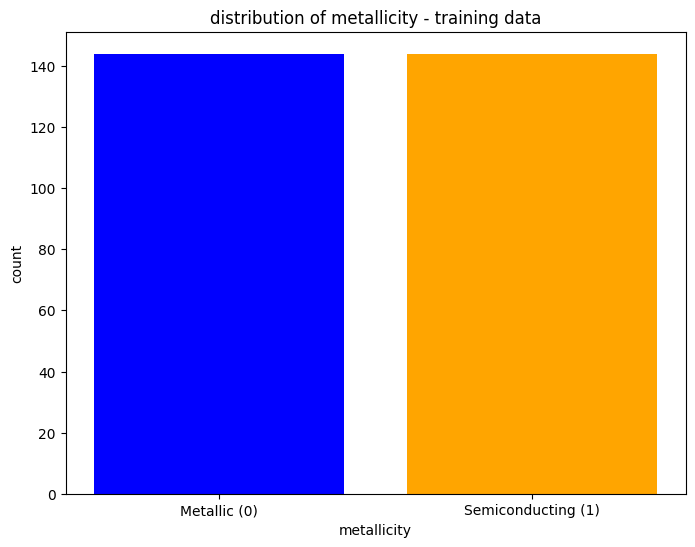

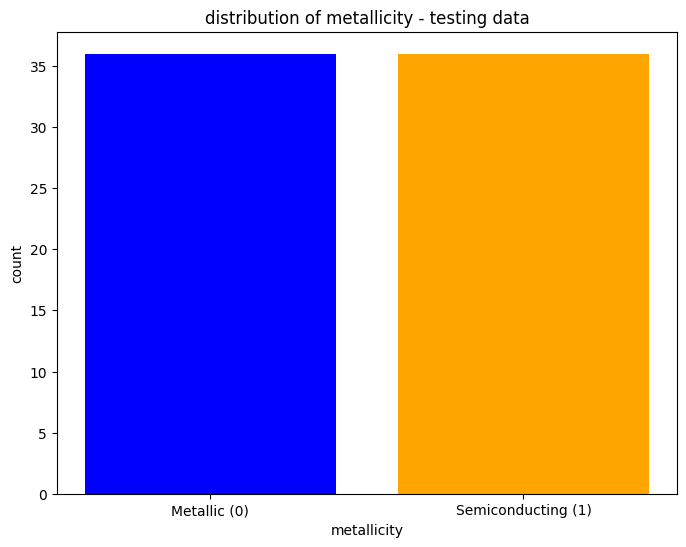

In [ ]:
# plotting data distributions
print("\ngenerating data distribution plots...")
# Plot training data distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_train.astype(str), counts_train, color=['blue', 'orange'])
plt.xticks(unique_train, ['Metallic (0)', 'Semiconducting (1)'])
plt.xlabel('metallicity')
plt.ylabel('count')
plt.title('distribution of metallicity - training data')
plt.savefig('distribution_train_mlp.png')
print("saved 'distribution_train_mlp.png'")

# Plot testing data distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_test.astype(str), counts_test, color=['blue', 'orange'])
plt.xticks(unique_test, ['Metallic (0)', 'Semiconducting (1)'])
plt.xlabel('metallicity')
plt.ylabel('count')
plt.title('distribution of metallicity - testing data')
plt.savefig('distribution_test_mlp.png')
print("saved 'distribution_test_mlp.png'")



In [ ]:
# converting to pytorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# defining our MLP model
class mlp_model(nn.Module):
    def __init__(self):
        super(mlp_model, self).__init__()
        self.net = nn.Sequential(
            # input layer must be 3 (for the 3 one-hot features)
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        # output layer
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.net(x)
        x = self.output_layer(x)
        return x

model = mlp_model()

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
model.to(device)

# define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Using device: cuda


In [ ]:
# training loop
print('start training')
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}')

end_time = time.time()
print('training finished')
total_training_time = end_time - start_time
print(f'total training time: {total_training_time:.2f} seconds')

# --- 11. Testing & Evaluation ---
print('\n start testing testing')
model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        predicted = torch.round(torch.sigmoid(outputs))
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

start training
epoch [10/100], loss: 0.0012
epoch [20/100], loss: 0.0005
epoch [30/100], loss: 0.0002
epoch [40/100], loss: 0.0001
epoch [50/100], loss: 0.0001
epoch [60/100], loss: 0.0001
epoch [70/100], loss: 0.0001
epoch [80/100], loss: 0.0000
epoch [90/100], loss: 0.0000
epoch [100/100], loss: 0.0000
training finished
total training time: 1.83 seconds

 start testing testing


accuracy of the model on the test samples: 100.00 %

classification Report
                    precision    recall  f1-score   support

      Metallic (0)       1.00      1.00      1.00        36
Semiconducting (1)       1.00      1.00      1.00        36

          accuracy                           1.00        72
         macro avg       1.00      1.00      1.00        72
      weighted avg       1.00      1.00      1.00        72


generating final plot
saved 'confusion_matrix_mlp.png'


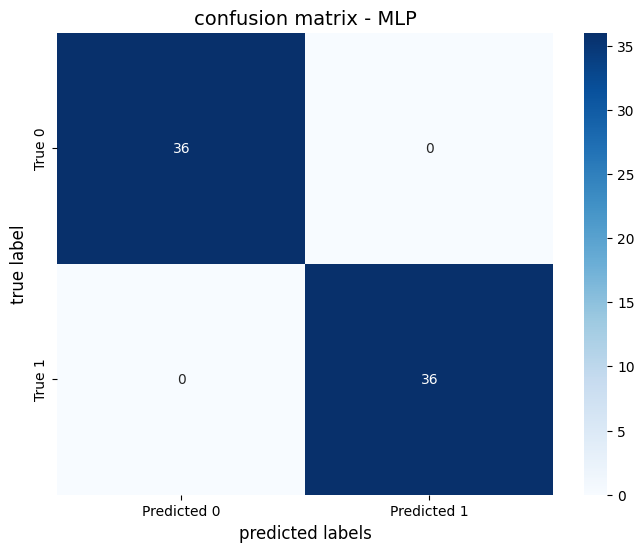

In [ ]:
# printing our results
y_true = np.array(y_true_list).ravel()
y_pred = np.array(y_pred_list).ravel()

accuracy = accuracy_score(y_true, y_pred)
print(f'accuracy of the model on the test samples: {accuracy*100:.2f} %\n')
target_names = ['Metallic (0)', 'Semiconducting (1)']
report = classification_report(y_true, y_pred, target_names=target_names)
print('classification Report')
print(report)

# --- 13. PLOT: Confusion Matrix ---
print("\ngenerating final plot")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('predicted labels', fontsize=12)
plt.ylabel('true label', fontsize=12)
plt.title('confusion matrix - MLP', fontsize=14)
plt.savefig('confusion_matrix_mlp.png')
print("saved 'confusion_matrix_mlp.png'")
plt.show()